Comparisons of locomotion predictions of different mechanistic latent variable models.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from disp import set_plot


STRAIN_KEY = '_'.join(['NM91', 'ZH23']).lower()
REG_KEY = 'ridge_alpha_10'

TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

# Basic comparison of single vs population fits using different neural models.

In [2]:
NRL_MDLS = [
#     'lin',  # linear neural model
#     'lin2e',  # linear neural model (two-exp fit)
#     'linr',  # linear neural model (fit w ridge regr)
    'linma',
#     'ln',  # linear-nonlinear model
    'lnma',  # linear-nonlinear model (two-exp fit)
#     'lnr',  # linear-nonlinear model (fit w ridge regr)
    'ma',  # mult-adapt neural model
#     'masoff',  # mult-adapt neural model with sine offset responses
]

LABELS = {
    'linma': 'Lin.',
    'lnma': 'LN',
    'ma': 'MA',
    'MTN': 'Motion',
}

In [3]:
# heuristic predictors
time_rslt = np.load(f'data/simple/mlv/heuristic/time_{STRAIN_KEY}_{TARG_BHV.lower()}_ignore_pre_song.npy', allow_pickle=True)[0]

# linear fits
lin_rslt = np.load(f'data/simple/mlv/lin_filter/rc_lin_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}_ignore_pre_song.npy', allow_pickle=True)[0]

# single-neuorn fits
single_rslts = [
    np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_single_{STRAIN_KEY}_{TARG_BHV.lower()}_ignore_pre_song.npy', allow_pickle=True)[0]
    for nrl_mdl in NRL_MDLS
]

# ppln fits
ppln_rslts = [
    np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}_masked.npy', allow_pickle=True)[0]
    for nrl_mdl in NRL_MDLS
]

# shuffled MA fit
shfl_rslt = np.load(f'data/simple/mlv/ma_shfl/baker_ma_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}.npy', allow_pickle=True)[0]

FileNotFoundError: [Errno 2] No such file or directory: 'data/simple/mlv/heuristic/time_nm91_zh23_mtn_ignore_pre_song.npy'

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(11, 4.5), tight_layout=True)
                
for ax, twdw in zip(axs, TWDWS):
    labels = []
    r2_mns = []
    r2_sems = []
    
    targ = f'{TARG_BHV}_MN_{twdw}'
    
    # heuristics
    labels.append('Timestamp')
    r2_mns.append(time_rslt['r2_test'][targ].mean())
    r2_sems.append(time_rslt['r2_test'][targ].std() / np.sqrt(time_rslt['nsplit']))
    
    # linear fits
    labels.append('Lin. filter')
    r2_mns.append(lin_rslt['r2_test'][targ].mean())
    r2_sems.append(lin_rslt['r2_test'][targ].std() / np.sqrt(lin_rslt['nsplit']))
    
    # single neuron results
    for nrl_mdl, single_rslt in zip(NRL_MDLS, single_rslts):
        r2_maxs = single_rslt['r2_test'][targ].max(axis=1)
        labels.append(f'{LABELS[nrl_mdl]} (single)')
        r2_mns.append(r2_maxs.mean())
        r2_sems.append(r2_maxs.std() / np.sqrt(len(r2_maxs)))
        
    # ppln results
    for nrl_mdl, ppln_rslt in zip(NRL_MDLS, ppln_rslts):
        labels.append(f'{LABELS[nrl_mdl]} (pop)')
        r2_mns.append(ppln_rslt['r2_test'][targ].mean())
        r2_sems.append(ppln_rslt['r2_test'][targ].std() / np.sqrt(ppln_rslt['nsplit']))
        
    # shuffled MA fit
    labels.append('MA (shuffled)')
    r2_mns.append(shfl_rslt['r2_test'][targ].mean())
    r2_sems.append(shfl_rslt['r2_test'][targ].std() / np.sqrt(shfl_rslt['nshfl']))
        
    r2_mns = np.array(r2_mns)
    r2_sems = np.array(r2_sems)
    
    ax.barh(-np.arange(len(r2_mns)), 100*r2_mns, xerr=100*r2_sems)
    ax.set_xlim(left=0)
    ax.set_yticks(-np.arange(len(labels)))
    ax.set_yticklabels(labels)
    set_plot(ax, x_label='Walking Speed Var. Expl. (%)', font_size=14)
    
fig.savefig('cosyne_2023/1d.svg')

# Behavioral predictions from perturbed surrogate population recordings

In [ ]:
KBHVS_FOLDERS_KEYS = [
    ('ma', 'neur_basic', 'Full MA pop.'),
    (None, None, None),
    ('ma_no_sel', 'ma_alt', 'No selectivity'),
    ('ma_pure_sel', 'ma_alt', 'Pure selectivity'),
#     ('ma_sine_sel', 'ma_alt', 'Sine selective'),
#     ('ma_pulse_sel', 'ma_alt', 'Pulse selective'),
    (None, None, None),
    ('ma_no_adapt', 'ma_alt', 'No adapt.'),
    ('ma_stim_inv_adapt', 'ma_alt', 'Stim-inv. adapt.'),
    (None, None, None),
    ('ma_fast_r_fast_a', 'ma_alt', r'$\tau_r$ fast, $\tau_a$ fast'),
    ('ma_fast_r_med_a', 'ma_alt', r'$\tau_r$ fast, $\tau_a$ med.'),
    ('ma_fast_r_slow_a', 'ma_alt', r'$\tau_r$ fast, $\tau_a$ slow'),
    (None, None, None),
    ('ma_med_r_fast_a', 'ma_alt', r'$\tau_r$ med, $\tau_a$ fast'),
    ('ma_med_r_med_a', 'ma_alt', r'$\tau_r$ med, $\tau_a$ med'),
    ('ma_med_r_slow_a', 'ma_alt', r'$\tau_r$ med, $\tau_a$ slow'),
    (None, None, None),
    ('ma_slow_r_fast_a', 'ma_alt', r'$\tau_r$ slow, $\tau_a$ fast'),
    ('ma_slow_r_med_a', 'ma_alt', r'$\tau_r$ slow, $\tau_a$ med'),
    ('ma_slow_r_slow_a', 'ma_alt', r'$\tau_r$ slow, $\tau_a$ slow'),
# #     ('ma_fast_r_fast_a', 'ma_alt', r'Fast $\tau_r$, fast $\tau_a$'),
#     ('ma_fast_r_fast_a', 'ma_alt', r'$.1 < \tau_a < 2$'),
#     ('ma_fast_r_med_a', 'ma_alt', r'$2 < \tau_a < 20$'),
#     ('ma_fast_r_slow_a', 'ma_alt', r'$20 < \tau_a < 120$'),
#     (None, None, None),
#     ('ma_med_r_fast_a', 'ma_alt', r'$.1 < \tau_a < 2$'),
#     ('ma_med_r_med_a', 'ma_alt', r'$2 < \tau_a < 20$'),
#     ('ma_med_r_slow_a', 'ma_alt', r'$20 < \tau_a < 120$'),
#     (None, None, None),
#     ('ma_slow_r_fast_a', 'ma_alt', r'$.1 < \tau_a < 2$'),
#     ('ma_slow_r_med_a', 'ma_alt', r'$2 < \tau_a < 20$'),
#     ('ma_slow_r_slow_a', 'ma_alt', r'$20 < \tau_a < 120$'),
]

rslts_1 = []
rslts_60 = []

for kbhv, folder, key in KBHVS_FOLDERS_KEYS:
    if folder is not None:
        fit_data = np.load(f'data/simple/mlv/{folder}/baker_{kbhv}_nm91_zh23_mtn_ridge_alpha_10.npy', allow_pickle=True)[0]

        nsplit = len(fit_data['r2_test']['MTN_MN_60'])

        r2_1 = fit_data['r2_test']['MTN_MN_1'].mean()
        err_1 = fit_data['r2_test']['MTN_MN_1'].std()/np.sqrt(nsplit)
        
        r2_60 = fit_data['r2_test']['MTN_MN_60'].mean()
        err_60 = fit_data['r2_test']['MTN_MN_60'].std()/np.sqrt(nsplit)
    else:
        r2_1 = np.nan
        err_1 = np.nan
        r2_60 = np.nan
        err_60 = np.nan
    
    rslts_1.append((key, r2_1, err_1))
    rslts_60.append((key, r2_60, err_60))

NameError: name 'rslts_1' is not defined

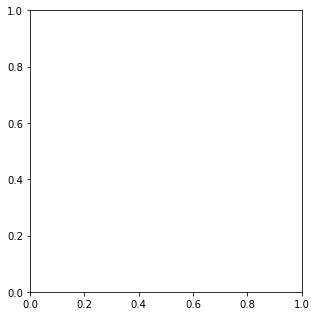

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5), tight_layout=True, sharey=True)

max_r2 = rslts_1[0][1]
for crslt, (key, r2, err) in enumerate(rslts_1):
    ax.barh([-crslt], [r2/max_r2], xerr=[err/max_r2], height=.7, color='k')

ax.axvline(1, color='gray', ls='--', lw=.5)

ax.set_yticks(-np.arange(len(rslts)))
ax.set_yticklabels([rslt[0] for rslt in rslts_1])

set_plot(ax, x_label='Rel. variance explained', font_size=14)

fig.savefig('cosyne_2023/2a.svg')